# Lego Harry Potter: TF-IDF

## Introduction

When it comes to the colour palette of the Harry Potter theme, the previous notebook (hp_initial-eda) focused entirely on counts of colours, whether that be by subtheme or year, or the proportions of bricks of different colours within individual sets. The visualisations in that notebook showed that there are several colours within the theme that make up a large percentage of parts within many sets, for example tan, both light and dark blueish gray, and black. This contributes strongly to the overall aesthetic of both the sets themselves and the theme as a whole.

However, it is not the only aspect of the colour palette of potential interest. A set may also contain a higher percentage of colours of bricks that are rarely, or never, found in other sets in the theme. This could be considered a defining aspect of the palette of that set. A similar pattern is found in language. Take a large a varied corpus of documents like English-language Wikipedia. Within that, many words, such as 'the' or 'is') occur very frequently in almost all articles, much like tan-coloured bricks in the Harry Potter theme. Other words, such as 'Lego' are found much more rarely overall, but will be found more often in articles about Lego. In those articles, the word 'Lego' should be considered more important than 'the', despite the latter being more common.

One numerical respresentation of this sort of importance is **term frequency - inverse document frequency** (TF-IDF). While normally applied to words within text documents, for reasons mentioned above it's perfectly applicable here to colours within Lego sets, with each part colour being considered a 'word' and each set a 'document'.

### So what is TF-IDF?

The TF-IDF statistic is the product of two components: the **term frequency** (TF) and the **inverse document frequency** (IDF). TF is a measure of how frequently a word is found within a single document - high frequency words have a high TF, and low frequency words a low TF. IDF, on the other hand, is a measure of how frequently a word appears in *all* documents. Because of how it's calculated (more on that later), the more documents in which a word occurs the lower the IDF value, and vice versa. When both parts are combined, the result is that terms that occur many times in few documents have a higher TF-IDF statistic than those that occur many times in many documents.

### The calculation

There are [many different ways](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) to calculate the TF-IDF value. What follows is a description of the method used by scikit-learn's TfidfTransformer:

**Step 1:**

Calculate the TF (term frequency) value:

$$\textrm{TF}(t, d) = \frac{n_{t,d}}{N_{d}}$$

where
- $n_{t,d}$ is the raw count of term $t$ in document $d$

While some methods weight the TF value, this does not appear to be done by the implementation in scikit-learn. I might be mistaken, though...

**Step 2:**

Calculate the IDF score by dividing the total number of documents by the number of documents containing term $t$ and taking the logarithm of the result. Scikit-learn smooths the IDF weight by adding 1 to the numerator and denominator:

$$\textrm{IDF}(t) = \log\left(\frac{1 + D}{1 + df(t)}\right) + 1$$

where
- $D$ is the total number of documents and
- $df(t)$ is the number of documents containing term $t$.

**Step 3:**
Compute the TF-IDF score by multiplying the TF and IDF values:

$$\textrm{TF-IDF}(t,d) = \textrm{TF}(t,d) \cdot \textrm{IDF}(t)$$

Scikit-learn also performs l2 normalization on the TF-IDF score.

## Libraries and setup

In [2]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd

import altair as alt

from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
DB_PATH = Path("../../data/db")

In [4]:
!ls {DB_PATH}

20190511115712.log  lego.db


In [5]:
conn = sqlite3.connect(str(DB_PATH / "lego.db"))

## Data

In [6]:
theme_order = ["Philosopher's Stone", "Chamber of Secrets", "Prisoner of Azkaban", "Goblet of Fire",
              "Order of the Phoenix", "Harry Potter", "Fantastic Beasts"]

### Related to parts and colours

In [7]:
cols = """sets.set_num, sets.name, sets.year, sets.num_parts, color_id,
        parts.part_num, inventory_parts.quantity, colors.rgb, colors.is_trans, colors.name as color_name,
        themes.name as theme_name, inventories.id as inv_id, parts.name as part_name"""

hp_parts_df = pd.read_sql_query(
    f"""SELECT {cols} FROM sets
    JOIN themes on sets.theme_id = themes.id
    JOIN inventories on sets.set_num = inventories.set_num
    JOIN inventory_parts on inventories.id = inventory_parts.inventory_id
    JOIN parts on inventory_parts.part_num = parts.part_num
    JOIN colors on inventory_parts.color_id = colors.id
    WHERE themes.name = 'Harry Potter'
        OR themes.name LIKE '%Sorcerer''s Stone%'
        OR themes.name = 'Chamber of Secrets'
        OR themes.name = 'Prisoner of Azkaban'
        OR themes.name = 'Goblet of Fire'
        OR themes.name = 'Order of the Phoenix'
        OR themes.name = 'Fantastic Beasts'""",
    conn)

In [8]:
dfs = [hp_parts_df]

In [9]:
for df in dfs:
    df.drop(df[df['year']==2019].index, axis=0, inplace=True)

In [10]:
for df in dfs:
    df.drop(df[(df['set_num']=='K4706-1') | (df['set_num']=='K4701-1') | (df['set_num']=='K4729-1') | (df['set_num']=='5000068-1')]\
            .index, axis=0, inplace=True)

In [11]:
# Fixes identically named sets
# Changes 'Sorcerer's Stone' to 'Philosopher's Stone'
for df in dfs:
    df.loc[df['theme_name']=="Sorcerer's Stone", 'theme_name'] = "Philosopher's Stone"
    df.loc[(df['name']=='Hogwarts Castle') & (df['theme_name']=='Order of the Phoenix'), 'name'] = 'Hogwarts (Third Edition)'
    df.loc[(df['name']=='Hogwarts Castle') & (df['theme_name']=="Philosopher's Stone"), 'name'] = 'Hogwarts (First Edition)'
    df.loc[(df['name']=='Diagon Alley') & (df['theme_name']=='Harry Potter'), 'name'] = 'Diagon Alley'
    df.loc[(df['name']=='Diagon Alley') & (df['theme_name']=='Fantastic Beasts'), 'name'] = 'Diagon Alley (micro)'
    df.loc[(df['name']=='Hogwarts Express') & (df['theme_name']=="Philosopher's Stone"), 'name'] = 'Hogwarts Express (1st Edition)'
    df.loc[(df['name']=='Hogwarts Express') & (df['theme_name']=='Fantastic Beasts'), 'name'] = 'Hogwarts Express (4th Edition)'

In [12]:
# Combines set_num and name columns
# It's easier for people to look up sets this way, but set_num by itself is opaque
for df in dfs:
    df['num_name'] = df['set_num'] + ": " + df["name"]

### Colours

In [13]:
# data groups the part name, its colour and the quantity of said part in said colour
# This expands the df into a row for every part (still grouped by colour)
hp_colors_df = hp_parts_df.reindex(hp_parts_df.index.repeat(hp_parts_df['quantity'])).reset_index().drop('index', axis=1)
hp_colors_df['hex'] = '#' + hp_colors_df['rgb']

In [14]:
hp_colors_df.head()

,set_num,name,year,num_parts,color_id,part_num,quantity,rgb,is_trans,color_name,theme_name,inv_id,part_name,num_name,hex
0,10217-1,Diagon Alley,2011,2031,0,10201,4,05131D,f,Black,Harry Potter,14029,Bracket 1 x 2 - 1 x 4 [Rounded Corners],10217-1: Diagon Alley,#05131D
1,10217-1,Diagon Alley,2011,2031,0,10201,4,05131D,f,Black,Harry Potter,14029,Bracket 1 x 2 - 1 x 4 [Rounded Corners],10217-1: Diagon Alley,#05131D
2,10217-1,Diagon Alley,2011,2031,0,10201,4,05131D,f,Black,Harry Potter,14029,Bracket 1 x 2 - 1 x 4 [Rounded Corners],10217-1: Diagon Alley,#05131D
3,10217-1,Diagon Alley,2011,2031,0,10201,4,05131D,f,Black,Harry Potter,14029,Bracket 1 x 2 - 1 x 4 [Rounded Corners],10217-1: Diagon Alley,#05131D
4,10217-1,Diagon Alley,2011,2031,71,10201,5,A0A5A9,f,Light Bluish Gray,Harry Potter,14029,Bracket 1 x 2 - 1 x 4 [Rounded Corners],10217-1: Diagon Alley,#A0A5A9


In [15]:
hp_colors_df.shape

(29946, 15)

## TF-IDF scores

The `TfidfTransformer` function requires a [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) representation of the data as an input. The below concatenates each hex colour code for each part in each set into a single string.

In [19]:
hp_palette_df = hp_colors_df.groupby('set_num')['hex']\
    .agg(lambda x: ', '.join(x))\
    .reset_index()\
    .rename(columns={'hex': 'palette'})

hp_palette_df.head()

,set_num,palette
0,10132-1,"#6C6E68, #6C6E68, #C91A09, #C91A09, #6C6E68, #..."
1,10217-1,"#05131D, #05131D, #05131D, #05131D, #A0A5A9, #..."
2,30110-1,"#6C6E68, #05131D, #05131D, #05131D, #A0A5A9, #..."
3,30111-1,"#E4CD9E, #0020A0, #F08F1C, #582A12, #582A12, #..."
4,30407-1,"#582A12, #582A12, #582A12, #A0A5A9, #582A12, #..."


In [23]:
# Compute TF-IDF scores
tfidf_vec = TfidfVectorizer()
tfidf_scores = tfidf_vec.fit_transform(hp_palette_df['palette'])
feature_names = tfidf_vec.get_feature_names()

In [24]:
tfidf_scores

<73x75 sparse matrix of type '<class 'numpy.float64'>'
	with 1220 stored elements in Compressed Sparse Row format>

`TfidfTransformer` returns a numpy sparse matrix. The below converts this back into a usable pandas dataframe:

In [31]:
tfidf_df = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)\
    .join(hp_palette_df['set_num'])\
    .melt(id_vars='set_num', var_name='hex', value_name='tf_idf')\
    .groupby(['set_num'])['tf_idf', 'hex']\
    .apply(lambda x: x.sort_values('tf_idf', ascending=False))\
    .reset_index((0,0))

In [32]:
tfidf_df = hp_parts_df[['set_num', 'name', 'num_name', 'theme_name']].drop_duplicates(subset=['set_num']).merge(tfidf_df, how='left')
tfidf_df['hex'] = tfidf_df['hex'] = '#' + tfidf_df['hex'].str.upper()

tfidf_df.head()

,set_num,name,num_name,theme_name,tf_idf,hex
0,10217-1,Diagon Alley,10217-1: Diagon Alley,Harry Potter,0.493880,#FFFFFF
1,10217-1,Diagon Alley,10217-1: Diagon Alley,Harry Potter,0.482384,#05131D
2,10217-1,Diagon Alley,10217-1: Diagon Alley,Harry Potter,0.397413,#582A12
3,10217-1,Diagon Alley,10217-1: Diagon Alley,Harry Potter,0.324206,#6C6E68
4,10217-1,Diagon Alley,10217-1: Diagon Alley,Harry Potter,0.259790,#E4CD9E


## Set colours by highest TF-IDF score

In [34]:
hex_codes = hp_colors_df[['hex', 'color_name']].drop_duplicates(subset=['hex']).reset_index().drop('index', axis=1)

In [39]:
largest_colors_tfidf = tfidf_df\
    .groupby('set_num')['theme_name', 'name', 'hex', 'tf_idf']\
    .apply(lambda grp: grp.nlargest(5, 'tf_idf'))\
    .reset_index().drop('level_1', axis=1)


largest_colors_tfidf = largest_colors_tfidf\
    .merge(hex_codes, on=['hex'])\
    .groupby(['set_num'])['theme_name', 'name', 'color_name', 'hex', 'tf_idf']\
    .apply(lambda x: x.sort_values('tf_idf', ascending=False))\
    .reset_index((0,0))

largest_colors_tfidf.head(10)

,set_num,theme_name,name,color_name,hex,tf_idf
0,10132-1,Prisoner of Azkaban,Motorized Hogwarts Express,Dark Bluish Gray,#6C6E68,0.573218
1,10132-1,Prisoner of Azkaban,Motorized Hogwarts Express,Black,#05131D,0.524511
2,10132-1,Prisoner of Azkaban,Motorized Hogwarts Express,Trans-Red,#C91A09,0.413765
3,10132-1,Prisoner of Azkaban,Motorized Hogwarts Express,Light Bluish Gray,#A0A5A9,0.346246
4,10132-1,Prisoner of Azkaban,Motorized Hogwarts Express,Dark Red,#720E0F,0.270928
5,10217-1,Harry Potter,Diagon Alley,White,#FFFFFF,0.493880
6,10217-1,Harry Potter,Diagon Alley,Black,#05131D,0.482384
7,10217-1,Harry Potter,Diagon Alley,Reddish Brown,#582A12,0.397413
8,10217-1,Harry Potter,Diagon Alley,Dark Bluish Gray,#6C6E68,0.324206
9,10217-1,Harry Potter,Diagon Alley,Tan,#E4CD9E,0.259790


### Philosopher's Stone

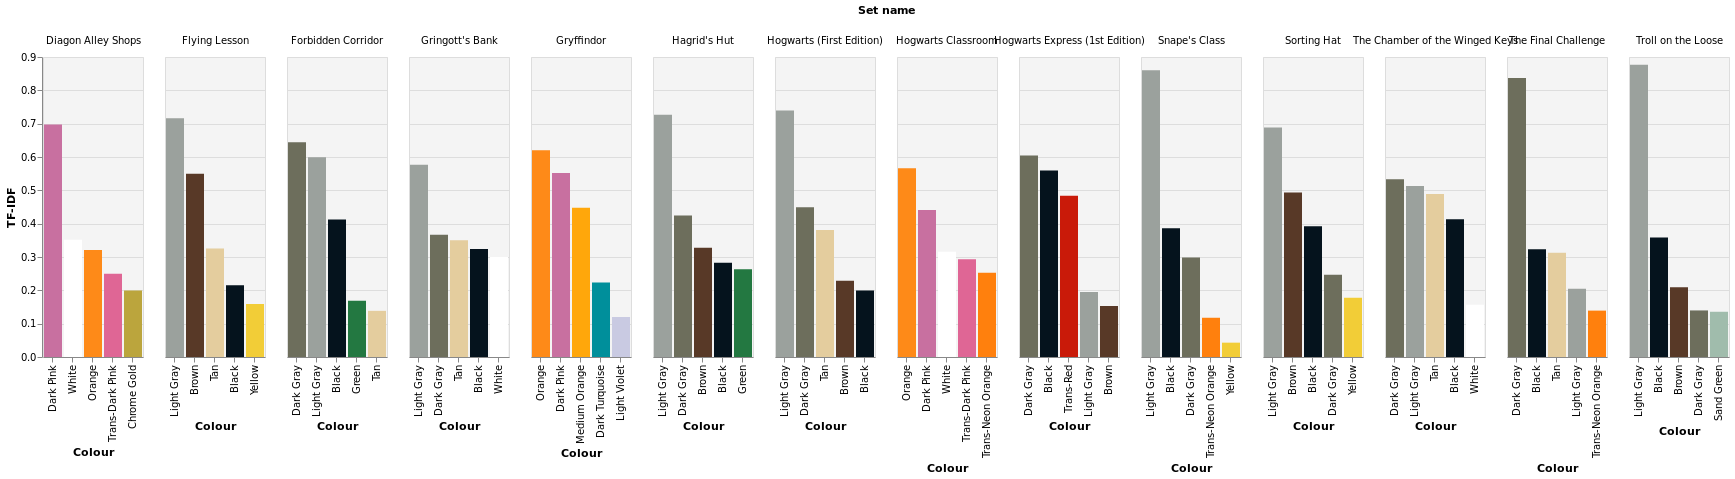

In [48]:
alt.Chart(largest_colors_tfidf[largest_colors_tfidf['theme_name']=="Philosopher's Stone"]).mark_bar().encode(
    y=alt.X('tf_idf', title='TF-IDF'),
    x=alt.X('color_name', sort=alt.Sort(field='tf_idf:Q', order='ascending'), title='Colour'),
    color=alt.Color("hex:N", scale=None, title='Colour'),
    tooltip=['hex'],
    column=alt.Column('name', title='Set name')
).resolve_scale(x='independent').configure_view(
    fill='#f4f4f4'
)

### Chamber of Secrets

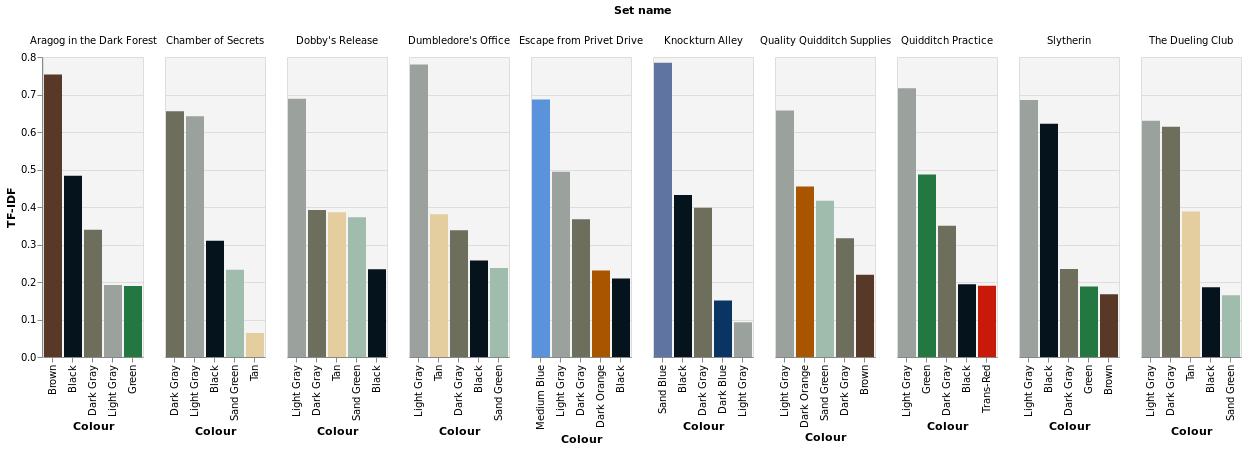

In [49]:
alt.Chart(largest_colors_tfidf[largest_colors_tfidf['theme_name']=="Chamber of Secrets"]).mark_bar().encode(
    y=alt.X('tf_idf', title='TF-IDF'),
    x=alt.X('color_name', sort=alt.Sort(field='tf_idf:Q', order='ascending'), title='Colour'),
    color=alt.Color("hex:N", scale=None, title='Colour'),
    tooltip=['hex'],
    column=alt.Column('name', title='Set name')
).resolve_scale(x='independent').configure_view(
    fill='#f4f4f4'
)

### Prisoner of Azkaban

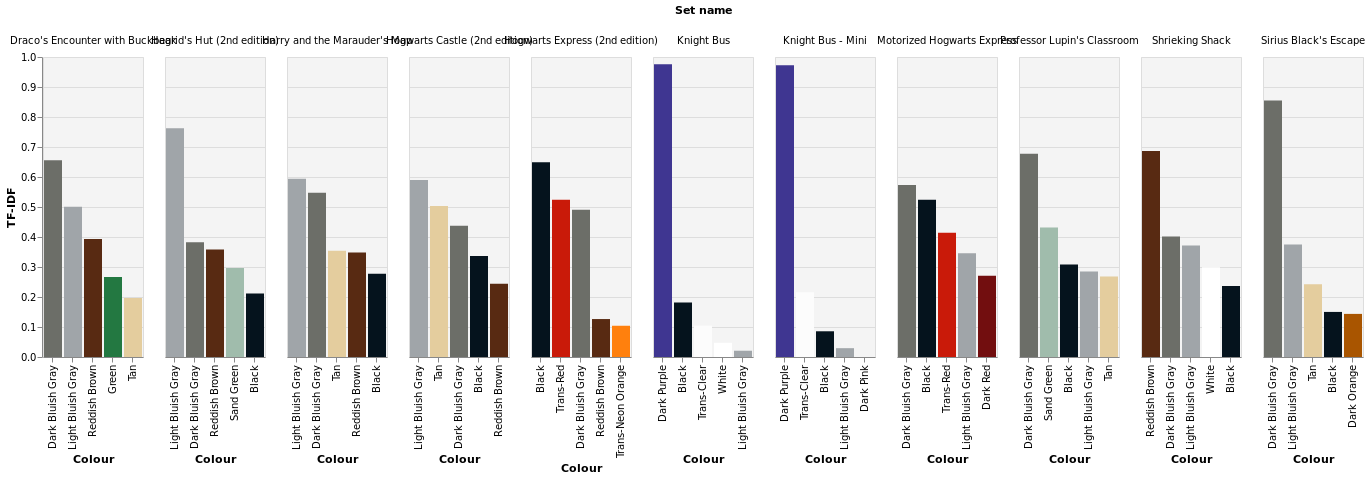

In [50]:
alt.Chart(largest_colors_tfidf[largest_colors_tfidf['theme_name']=="Prisoner of Azkaban"]).mark_bar().encode(
    y=alt.X('tf_idf', title='TF-IDF'),
    x=alt.X('color_name', sort=alt.Sort(field='tf_idf:Q', order='ascending'), title='Colour'),
    color=alt.Color("hex:N", scale=None, title='Colour'),
    tooltip=['hex'],
    column=alt.Column('name', title='Set name')
).resolve_scale(x='independent').configure_view(
    fill='#f4f4f4'
)

### Goblet of Fire

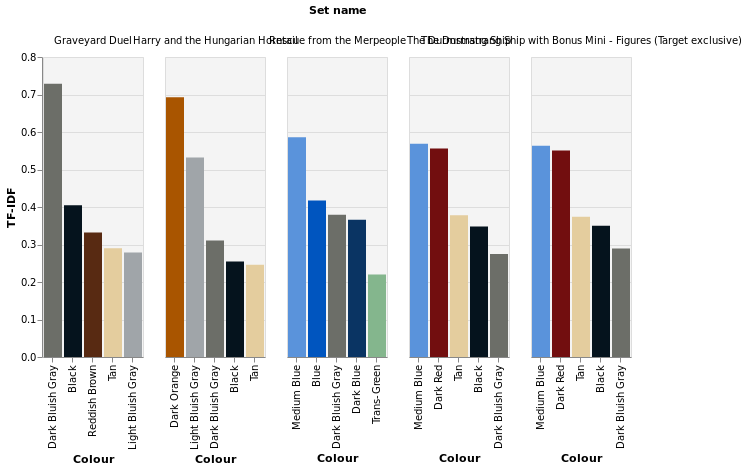

In [51]:
alt.Chart(largest_colors_tfidf[largest_colors_tfidf['theme_name']=="Goblet of Fire"]).mark_bar().encode(
    y=alt.X('tf_idf', title='TF-IDF'),
    x=alt.X('color_name', sort=alt.Sort(field='tf_idf:Q', order='ascending'), title='Colour'),
    color=alt.Color("hex:N", scale=None, title='Colour'),
    tooltip=['hex'],
    column=alt.Column('name', title='Set name')
).resolve_scale(x='independent').configure_view(
    fill='#f4f4f4'
)

### Order of the Phoenix

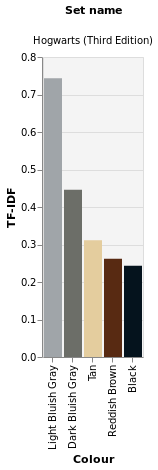

In [52]:
alt.Chart(largest_colors_tfidf[largest_colors_tfidf['theme_name']=="Order of the Phoenix"]).mark_bar().encode(
    y=alt.X('tf_idf', title='TF-IDF'),
    x=alt.X('color_name', sort=alt.Sort(field='tf_idf:Q', order='ascending'), title='Colour'),
    color=alt.Color("hex:N", scale=None, title='Colour'),
    tooltip=['hex'],
    column=alt.Column('name', title='Set name')
).resolve_scale(x='independent').configure_view(
    fill='#f4f4f4'
)

### Harry Potter

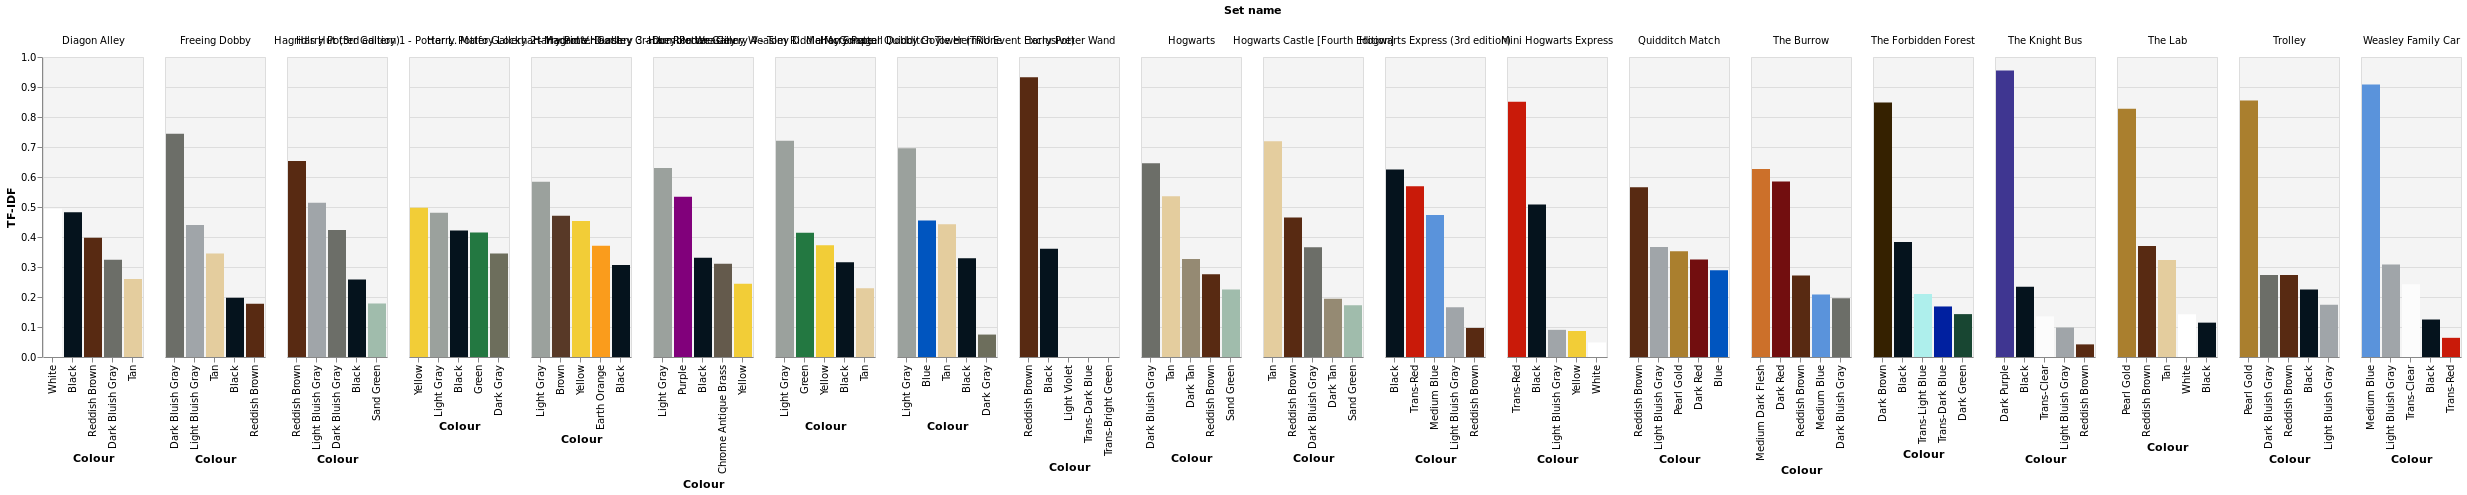

In [53]:
alt.Chart(largest_colors_tfidf[largest_colors_tfidf['theme_name']=="Harry Potter"]).mark_bar().encode(
    y=alt.X('tf_idf', title='TF-IDF'),
    x=alt.X('color_name', sort=alt.Sort(field='tf_idf:Q', order='ascending'), title='Colour'),
    color=alt.Color("hex:N", scale=None, title='Colour'),
    tooltip=['hex'],
    column=alt.Column('name', title='Set name')
).resolve_scale(x='independent').configure_view(
    fill='#f4f4f4'
)

### Fantastic Beasts

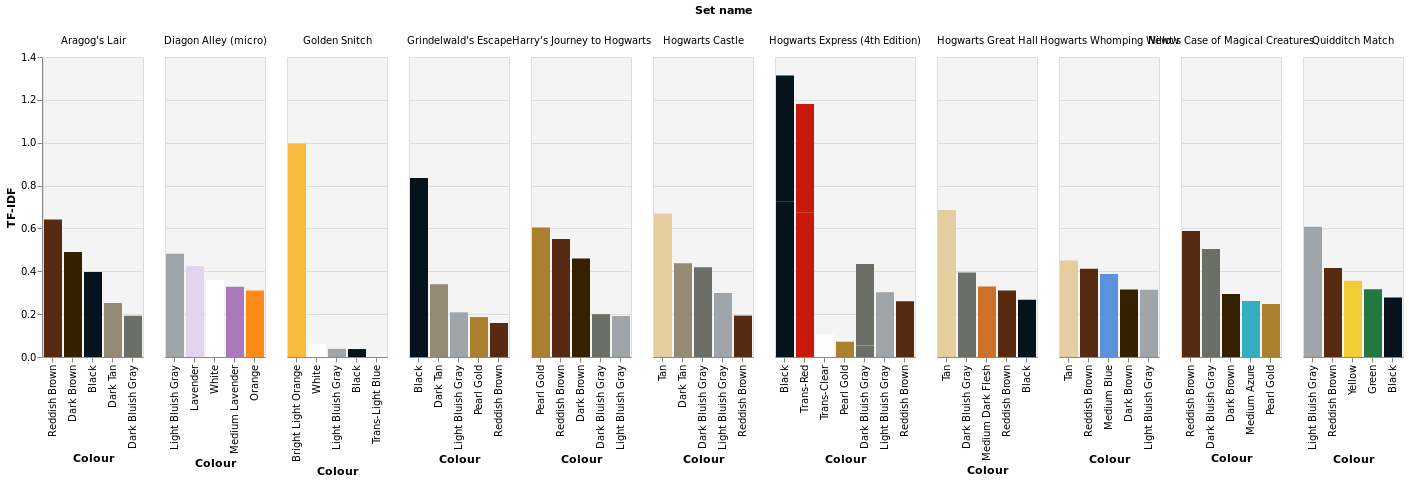

In [54]:
alt.Chart(largest_colors_tfidf[largest_colors_tfidf['theme_name']=="Fantastic Beasts"]).mark_bar().encode(
    y=alt.X('tf_idf', title='TF-IDF'),
    x=alt.X('color_name', sort=alt.Sort(field='tf_idf:Q', order='ascending'), title='Colour'),
    color=alt.Color("hex:N", scale=None, title='Colour'),
    tooltip=['hex'],
    column=alt.Column('name', title='Set name')
).resolve_scale(x='independent').configure_view(
    fill='#f4f4f4'
)